In [2]:
import pandas as pd
import prince
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve
import xgboost as xgb

###### Assumption 1 - Missing lab values are normal = 0
###### Problem 1 - Some zipcodes are from Hawaii. Distance is very high.

In [3]:
X_clin = pd.read_csv('DiscreteTrainData.csv')
X = X_clin.copy()

In [4]:
# Drop rows with missing charge data
X.dropna(subset=['CHARGE_FLAG_85pctile'], inplace=True)
Y = X.CHARGE_FLAG_85pctile

X.drop([ 'CHARGE_FLAG_85pctile', 'AUTO_ID', 'PAT_ID', 'PAT_MRN_ID'], axis=1, inplace=True)

In [5]:
# Encode all str to integers. Keep nulls as null

from sklearn.preprocessing import LabelEncoder
le_map={}
for c in X.columns:
    if X[c].dtype=='O':
        nan_ix = X[c].isnull()
        le_map[c] = LabelEncoder().fit(X[c].fillna('zznan'))
        X[c] = le_map[c].transform(X[c].fillna('zznan'))
        X[c].ix[nan_ix] = np.nan 

D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
D:\MiscSoftware\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=0.33, random_state=3)

# XGBOOST

In [15]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_estimators': [int(x) for x in np.linspace(40, 150, num = 5)],
#                'min_child_weight': [2],
#                'max_depth': [2, 5, 10, 20],
#                'reg_lambda': [0.5, 1],
#                'scale_pos_weight': [2, 3],
#                'colsample_bytree':[0.2, 0.3, 0.4]}

# grid = GridSearchCV(xgb.XGBClassifier(learning_rate=0.05), param_grid, return_train_score=True,  n_jobs = -1)
# grid.fit(xtr, ytr)
# winner = grid.best_estimator_
# winner

D:\MiscSoftware\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=1)

In [7]:
winner = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=1)
winner.fit(xtr, ytr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=1)

In [8]:
print("Train Score: ", winner.score(xtr,ytr))
print("Test Score: ", winner.score(xte, yte))
print("AUC: ", roc_auc_score(yte, winner.predict(xte)))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(xte)))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))
print("\n\n",sorted(list(zip(X.columns, winner.feature_importances_)), key=lambda x:x[1], reverse=True))

Train Score:  0.9093610698365527
Test Score:  0.8984924623115578
AUC:  0.7484262627269254
ConfMat: 
 [[818  36]
 [ 65  76]]
Train Label_Count:  [1708  311]
Test Label_Count:  [854 141]


 [('HEMO', 0.26615128), ('MONO_EVER_HIGH', 0.20993672), ('ENC_OFF', 0.1044374), ('ENC_TEL', 0.08389707), ('EOS_EVER_HIGH', 0.039495956), ('CRP', 0.03540693), ('ESR', 0.023868915), ('ENC_CONSULT', 0.023005355), ('VITD_LAB', 0.020622898), ('SIBDQ', 0.01843616), ('ANTIBIOTICS', 0.015539477), ('Vitamin_D', 0.015460146), ('EMPLOYMENT_STATUS', 0.014302653), ('TOBACCO_USE', 0.012502749), ('ENC_PROC', 0.011852687), ('Immunomodulators', 0.010728064), ('PSYCH', 0.010240208), ('ANTI_IL12', 0.009898516), ('DISTANCE_KM', 0.009839148), ('ALBUMIN', 0.0095426515), ('ANTI_TNF', 0.009472058), ('5_ASA', 0.008827482), ('AGE', 0.007881226), ('GENDER', 0.0073645567), ('PSYCH_DX', 0.0065508904), ('Systemic_steroids', 0.005876512), ('ANTI_INTEGRIN', 0.0049881223), ('MARITAL_STATUS', 0.0038741494)]


In [19]:
import pickle
with open('XGB_Discrete.pickle', 'wb') as f:
    pickle.dump(winner, f)

In [9]:
misclassified = X_clin.ix[xte.index].copy()
# misclassified['CHARGE'] = X_cont.ix[misclassified.index]['ANNUAL_AVG_CHARGE']
misclassified['y_true'] = yte
misclassified['y_pred'] = winner.predict(xte)
misclassified['predict_proba'] = winner.predict_proba(xte)[:,1]
misclassified['confidence'] = list(map(max, winner.predict_proba(xte)))

D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [17]:
calib = misclassified[['y_true', 'y_pred', 'predict_proba', 'confidence']]
bins = np.arange(0,1.1,0.1)
calib['bin'] = pd.cut(calib.predict_proba, bins)
calib['correct'] = np.where(calib.y_true==calib.y_pred, 1, 0)
calib[['y_true0', 'y_true1']] = pd.get_dummies(calib.y_true)
calib2 = pd.DataFrame()
calib2['bincount'] = calib.groupby('bin').y_pred.count()
calib2['acc'] = calib.groupby('bin').correct.mean()
calib2['prevalence1_obs'] = calib.groupby('bin').y_true1.sum()/calib2.bincount
calib2['prevalence0_obs'] = calib.groupby('bin').y_true0.sum()/calib2.bincount
calib2['binR'] = bins[1:]
calib2.drop(calib2.tail(1).index,inplace=True)
calib2

D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\MiscSoftware\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\MiscSoftware\Anaconda\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,bincount,acc,prevalence1_obs,prevalence0_obs,binR
bin,,,,,
"(0.0, 0.1]",85,1.000000,0.000000,1.000000,0.1
"(0.1, 0.2]",429,0.988345,0.011655,0.988345,0.2
"(0.2, 0.3]",200,0.920000,0.080000,0.920000,0.3
"(0.3, 0.4]",104,0.798077,0.201923,0.798077,0.4
"(0.4, 0.5]",65,0.646154,0.353846,0.646154,0.5
"(0.5, 0.6]",52,0.480769,0.480769,0.519231,0.6
"(0.6, 0.7]",35,0.771429,0.771429,0.228571,0.7
"(0.7, 0.8]",24,0.958333,0.958333,0.041667,0.8
"(0.8, 0.9]",1,1.000000,1.000000,0.000000,0.9


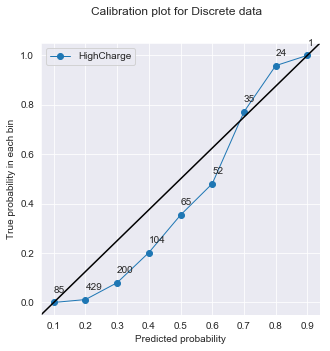

In [26]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(calib2['binR'], calib2['prevalence1_obs'], marker='o', linewidth=1, label='HighCharge')
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Discrete data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.xaxis.set_ticks(calib2['binR'])

for _,row in calib2.iterrows():
    ax.annotate(int(row['bincount']), (row['binR'], row['prevalence1_obs']+0.04))
    
plt.legend()
plt.show()

In [ ]:
with pd.ExcelWriter('XGBoostAnalysis_CDUC.xlsx') as writer:  # doctest: +SKIP
    misclassified.to_excel(writer, sheet_
                           name='ALL_PRED')
    misclassified.sort_values(by='SIBDQ', ascending=True).head(20).to_excel(writer, sheet_name='TOP20_LOW_SIBDQ')
    misclassified.sort_values(by='CHARGE', ascending=False).head(20).to_excel(writer, sheet_name='TOP20_HIGH_CHARGE')
    misclassified[misclassified.y_true==misclassified.y_pred].to_excel(writer, sheet_name='CORRECT_PREDS')
    misclassified[misclassified.y_true!=misclassified.y_pred].to_excel(writer, sheet_name='WRONG_PREDS')

In [27]:
confident_preds = misclassified[misclassified.confidence>=0.7]
confident_preds[confident_preds.y_true==confident_preds.y_pred].shape[0]/confident_preds.shape[0]

0.9702300405953992

In [28]:
confident_preds.shape[0]

739

In [20]:
misclassified.shape[0]

995

No handles with labels found to put in legend.


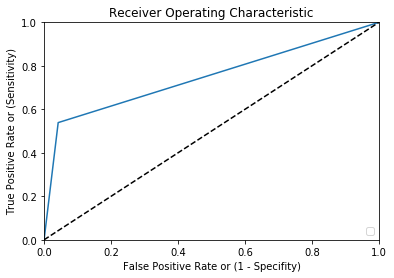

In [26]:
fpr, tpr, thresholds = roc_curve(yte, winner.predict(xte))
# roc_auc = auc(false_positive_rate, true_positive_rate)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# SVM

In [7]:
X_SVM = X.copy()
X_SVM.drop(['SIBDQ', 'PSYCH_DX'], axis=1, inplace=True)
X_SVM.dropna(subset=['PSYCH'], inplace=True)
X_SVM.fillna(0, inplace=True)

In [8]:
Y_SVM = Y[X_SVM.index]
xtr, xte, ytr, yte = train_test_split(X_SVM, Y_SVM, test_size=0.33, random_state=3)

In [9]:
scaler = StandardScaler().fit(xtr)

kfold=5
results = []
for c in [5, 8, 12]:
    for gamma in [0.01, 0.05, 0.1]:
        scores = cross_val_score(SVC(C=c, gamma=gamma), scaler.transform(xtr), ytr, cv=kfold)
        mean_score = np.mean(scores)
        results.append((c, gamma, mean_score))

best_c, best_gamma, best_score = max(results, key=lambda tup:tup[2])
winner = SVC(C=best_c, gamma=best_gamma).fit(scaler.transform(xtr), ytr)



In [10]:
print("Train Score: ", best_score)
print("Test Score: ", winner.score(scaler.transform(xte), yte))
print("AUC: ", roc_auc_score(yte, winner.predict(scaler.transform(xte))))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(scaler.transform(xte))))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))

Train Score:  0.8725445536641893
Test Score:  0.8649214659685864
AUC:  0.672507281402987
ConfMat: 
 [[764  28]
 [101  62]]
Train Label_Count:  [1655  283]
Test Label_Count:  [792 163]


### Without scaling features

In [11]:
kfold=5
results = []
for c in [5, 8, 12]:
    for gamma in [0.01, 0.05, 0.1]:
        scores = cross_val_score(SVC(C=c, gamma=gamma), xtr, ytr, cv=kfold)
        mean_score = np.mean(scores)
        results.append((c, gamma, mean_score))

best_c, best_gamma, best_score = max(results, key=lambda tup:tup[2])
winner = SVC(C=best_c, gamma=best_gamma).fit(xtr, ytr)



In [12]:
print("Train Score: ", best_score)
print("Test Score: ", winner.score(xte, yte))
print("AUC: ", roc_auc_score(yte, winner.predict(xte)))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(xte)))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))

Train Score:  0.870998161911612
Test Score:  0.8617801047120419
AUC:  0.6365069405713579
ConfMat: 
 [[775  17]
 [115  48]]
Train Label_Count:  [1655  283]
Test Label_Count:  [792 163]


# RANDOMFOREST

In [37]:
xtr, xte, ytr, yte = train_test_split(X_SVM, Y_SVM, test_size=0.33, random_state=3)

In [40]:
# Number of features to consider at every split
max_features = [10, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(60, 100, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(90, 150, num = 3)],
               'max_features': max_features,
               'max_depth': [5,10],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':['balanced', 'balanced_subsample']}
rf_gridsearch = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_gridsearch.fit(xtr, ytr)

D:\MiscSoftware\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   13.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': [90, 120, 150], 'max_features': [10, 'sqrt'], 'max_depth': [5, 10], 'min_samples_split': [5], 'min_samples_leaf': [2], 'bootstrap': [True], 'class_weight': ['balanced', 'balanced_subsample']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [41]:
winner = rf_gridsearch.best_estimator_
print("Best estimator: \n",winner)
print("Train Score: ", winner.score(xtr,ytr))
print("Test Score: ", winner.score(xte, yte))
print("AUC: ", roc_auc_score(yte, winner.predict(xte)))
print("ConfMat: \n",confusion_matrix(yte, winner.predict(xte)))
print("Train Label_Count: ", np.bincount(ytr))
print("Test Label_Count: ", np.bincount(yte))
print("\n\n",sorted(list(zip(X.columns, winner.feature_importances_)), key=lambda x:x[1], reverse=True))

Best estimator: 
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Train Score:  0.9643962848297214
Test Score:  0.8513089005235602
AUC:  0.7349491851025594
ConfMat: 
 [[722  70]
 [ 72  91]]
Train Label_Count:  [1655  283]
Test Label_Count:  [792 163]


 [('ALBUMIN', 0.26698776889641035), ('EOS_EVER_HIGH', 0.1274543449624691), ('ENC_PROC', 0.059541348207631455), ('ENC_CONSULT', 0.04912262764468774), ('ENC_TEL', 0.03334478523488772), ('ENC_OFF', 0.032483866904736425), ('AGE', 0.031971177719730334), ('ANTIBIOTICS', 0.031373243219543545), ('EMPLOYMENT_STATUS', 0.02964809284076977), ('DISTANCE_KM', 0.029189552378385355),

In [63]:
xx = pd.DataFrame(index=X_SVM.index, columns=X_SVM.columns)
for c in X_SVM.columns:
        xx[c] = le_map[c].inverse_transform(X_SVM[c].astype(int))
pd.concat([xx, Y_SVM], axis=1).to_csv('DiscreteTrainData_FillNA.csv', index=False)